# MNIST Digits Classification using Neural Networks



In this part we will implement our first Neural Network!
We will use fully connecter Neural Network in order to classify handwritten digits. We will use the well known MNIST dataset. The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning.
![img](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

## Imports

In [1]:
#importing modules that will be in use
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import time
import copy


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split



Mount your drive in order to run locally with colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/HomeWorks/HomeWork-DeepLearning/assignment2/
from utils import *

Mounted at /content/drive
/content/drive/MyDrive/HomeWorks/HomeWork-DeepLearning/assignment2


**QUESTION 1**: What are the problems with sigmoid?

**ANSWER**: sigmoid has variety of problems. 
1. The function isn't centerd around 0.
2. Vanishing gradient. On multi-layerd deep networks the gradient becomes very close to 0. So, weight doesn’t get updated much leading to very slow convergence
also, the gardient might reach 0, so learning wont occur.









here we will implement the sigmoid activation function and it's gradient. You should not use any build-in function of sigmoid.

In [3]:

def sigmoid(x):
    # impement the sigmoid funciton
    # ====== YOUR CODE: ======
    temp = 1 + torch.exp(-x)
    sig = 1/temp
    # ========================
    return sig



def softmax(x):
    """
  Softmax loss function, should be implemented in a vectorized fashion (without loops)


  Inputs:
  - X: A torch array of shape (N, C) containing a minibatch of data.
  Returns:
  - probabilities: A torch array of shape (N, C) containing the softmax probabilities.

     """
    #for stability (do not change)
    max_per_row, inds = torch.max(x, dim=1)
    x = (x.T - max_per_row).T
    # ====== YOUR CODE: ======
    probabilities = torch.exp(x) / torch.sum(torch.exp(x), axis=1, keepdims=True) 
    # ========================
    return probabilities

Implement a fully-vectorized loss function for the Softmax classifier.


In [4]:
def cross_entropy_error(y, t):
    """
    Inputs:

    - t:  A torch array of shape (N,C) containing  a minibatch of training label. it is a one-hot array, 
      with t[GT]=1 and t=0 elsewhere, where GT is the ground truth label ; tr
    - y: A torch array of shape (N, C) containing the softmax probabilities (the NN's output).

    Returns:
    - loss as single float (do not forget to divide by the number of samples in the minibatch (N))
    """
    # ====== YOUR CODE: ======   
    # Compute loss 
    loss = -torch.sum(t*torch.log(y))
    error = loss/float(y.shape[0])
    # ========================
    return error

In [5]:
def get_accuracy(y,t):
    """
    Computes the accuracy of the NN's predictions.
    Inputs:
    - t:  A torch array of shape (N,C) containing training labels, it is a one-hot array, 
      with t[GT]=1 and t=0 elsewhere, where GT is the ground truth label ; 
    - y: the torch probabilities for the minibatch (at the end of the forward pass) of shape (N,C)
    Returns:
    - accuracy: a single float of the average accuracy.
    """
    # ====== YOUR CODE: ======   
    _,pred = torch.max(y,1)
    correct = 0
    samples = t.shape[0]
    #correct = (t[i][pred[i]] == 1 for i in range(samples)).sum().item()
    for i in range (samples):
      if t[i][pred[i]] == 1:
       correct+= 1
    accuracy = 100*correct/samples 
    # ========================    
    return accuracy



## Fully-connected Network

We will design and train a two-layer fully-connected neural network with sigmoid nonlinearity and
softmax cross entropy loss. We assume an input dimension of D=784, a hidden dimension of H, and perform classification over C classes.

The architecture should be fullyconnected -> sigmoid -> fullyconnected -> softmax.

We will use torch.nn for the linear functions



### config

In [6]:
args={}
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']=15  #The number of Epochs
args['validation_ratio']=0.15 #The validation ratio from training set  
args['eval_every']=1 #Will evaluate the model ever <eval_every> epochs

## load the data

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [8]:
def create_train_validation_loaders(dataset: Dataset, 
                                         validation_ratio,
                                         batch_size=100):
    """
    Splits a dataset into a train and validation set, returning a
    DataLoader for each.
    :param dataset: The original dataset.
    :param validation_ratio: Ratio (in range 0,1) of the validation set size to
        total dataset size.
    :param batch_size: Batch size the loaders will return from each set.
    :return: A tuple of train, validation and test DataLoader instances.
    """
    if not(0.0 < validation_ratio < 1.0):
        raise ValueError(validation_ratio)
        
        
    # TODO: Create two DataLoader instances, dataloader_train and dataloader_valid.
    # They should together represent a train/validation split of the given
    # dataset. Make sure that:
    # 1. Validation set size is validation_ratio * total number of samples.
    # 2. No sample is in both datasets. You can select samples at random
    #    from the dataset.
    # 3. you use shuffle=True in the train dataloader and shuffle=False in the validation dataloder
    

    # ====== YOUR CODE: ======
    dl_train , dl_valid= train_test_split(dataset, test_size=validation_ratio)
    dl_train = torch.utils.data.DataLoader(dl_train, batch_size, shuffle=True, num_workers=2)
    dl_valid = torch.utils.data.DataLoader(dl_valid, batch_size, shuffle=False, num_workers=2)
    # ========================

    return dl_train, dl_valid

In [9]:
#load the data
dataset = datasets.MNIST('./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor(),
                                                       transforms.Normalize((0.1307,), (0.3081,))])
                        )

train_loader, val_loader = create_train_validation_loaders(dataset, 
                                                           validation_ratio = args['validation_ratio'],
                                                           batch_size= args['batch_size'])

In [10]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=False)

In [11]:
dataloaders = {'training':train_loader,
               'val':val_loader,
               'test':test_loader
              }

## Fully connected Neural Network

In [12]:
class FullyConnectedNeuralNetwork(nn.Module):
    #This defines the structure of the NN.
    def __init__(self,
                 hidden_layer_dim
                 ):
      super(FullyConnectedNeuralNetwork, self).__init__()
      # Define the model layers. 
      # Use the torch.nn.Linear layers. Set the hidden layer dim to hidden_layer_dim. 
      # Notice that the input dim is 784 and the output dim is 10 (number of classes).
      # ====== YOUR CODE: ======
      self.fc1 = nn.Linear(784, hidden_layer_dim)
      self.fc2 = nn.Linear(hidden_layer_dim, 10)
      # ========================

    def forward(self, x):
      x = torch.flatten(x, start_dim=1,end_dim=-1)
      # ====== YOUR CODE: ======
      y=self.fc1(x)
      y = sigmoid(y)
      y = self.fc2(y)
      y = softmax(y)
      # ========================
      return y

The following functions will train our model

In [13]:
def forward_one_epoch(loader,
                      optimizer,
                      net,
                      mode,
                      progress_bar_str,
                      num_of_epochs
                     ):
    

    losses, cur_accuracies = [], []
    all_preds,all_targets = [], []
    for batch_idx, (inputs, targets) in enumerate(loader):
        
        if mode == Mode.training:
            optimizer.zero_grad()
            
        inputs, targets =inputs.to(device), targets.to(device)
        outputs = net(inputs)
        targets = F.one_hot(targets, num_classes=10)
        loss = cross_entropy_error(outputs, targets)
        losses.append(loss.item())

        if mode == Mode.training:
            #do a step 
            loss.backward()
            optimizer.step()
            
        if len(targets.shape) ==2:
            cur_accuracies.append(get_accuracy(outputs, targets))
            
        if batch_idx %20 ==0:
            progress_bar(batch_idx, len(loader), progress_bar_str
                   % (num_of_epochs, np.mean(losses), losses[-1], np.mean(cur_accuracies)))
            
        targets_cpu = targets.cpu().data.numpy()
        outputs_cpu = [i.cpu().data.numpy() for i in outputs]
        outputs_cpu = np.argmax(outputs_cpu, axis=1)

        all_targets.extend(targets_cpu)
        all_preds.extend(outputs_cpu)

        del inputs, targets, outputs
        torch.cuda.empty_cache()


    return losses, cur_accuracies, all_targets, all_preds




In [14]:
def train(args, dataloaders):
  seed = 0
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(seed)

  model = FullyConnectedNeuralNetwork(hidden_layer_dim = args['hidden_layer_dim'])
  model = model.to(device)

  optimizer = torch.optim.SGD(model.parameters(), args['lr'])

  training_accuracies, val_accuracies = [], []
  training_losses, val_losses = [], [] 


  training_loader = dataloaders['training']
  val_loader = dataloaders['val']
  test_loader = dataloaders['test']

  best_acc = -1

  #start training
  for epoch in range(1, args['epochs']+1):

      #training
      model = model.train()

      progress_bar_str = 'Train: repeat %d -- Mean Loss: %.3f | Last Loss: %.3f | Train Acc: %.3f%%' 

      losses, cur_training_accuracies, _,_ =  forward_one_epoch(
          loader = training_loader,
          optimizer = optimizer,
          net = model,
          mode = Mode.training,
          progress_bar_str = progress_bar_str,
          num_of_epochs = epoch)


      train_epoch_acc = np.mean(cur_training_accuracies)
      train_epoch_loss= np.mean(losses)
      sys.stdout.flush()
      print()
      print(f'Train epoch {epoch}: accuracy {train_epoch_acc}, loss {train_epoch_loss}', flush=True)
      training_accuracies.append(train_epoch_acc)
      training_losses.append(train_epoch_loss)



      # validation
      model.eval()
      if (epoch-1)%args['eval_every']==0:
          progress_bar_str = 'Validation: repeat %d -- Mean Loss: %.3f | Last Loss: %.3f | val Acc: %.3f%%'

          losses, cur_val_accuracies,_,_ =  forward_one_epoch(val_loader,
                                                                optimizer,
                                                                model,
                                                                Mode.validation,
                                                                progress_bar_str,
                                                                epoch
                                                              )
          val_epoch_acc= np.mean(cur_val_accuracies)
          val_epoch_loss= np.mean(losses)
          sys.stdout.flush()
          val_accuracies.append(val_epoch_acc)

          val_epoch_acc = np.round(val_epoch_acc,3)
          print()
          print(f'Validation epoch {epoch//args["eval_every"]}: accuracy {val_epoch_acc}, loss {val_epoch_loss}', flush=True)
          val_losses.append(val_epoch_loss)
          
          cur_acc_loss = {
            'training_accuracies':training_accuracies,
            'val_accuracies':val_accuracies,
            'training_losses':training_losses,
            'val_losses':val_losses
                        }

          if best_acc +0.001 < val_epoch_acc:

              best_acc = val_epoch_acc
              best_acc_epoch = epoch

              print(f'========== new best model! epoch {best_acc_epoch}, accuracy {best_acc}  ==========')
              best_model = copy.deepcopy(model)

              
  progress_bar_str = 'Test: repeat %d -- Mean Loss: %.3f | Last Loss: %.3f | Acc: %.3f%%'
  test_losses, test_cur_test_accuracies, test_all_targets, test_all_preds = forward_one_epoch(test_loader,
                                                                None,
                                                                best_model,
                                                                Mode.test,
                                                                progress_bar_str,
                                                                0)

  test_epoch_acc= np.mean(test_cur_test_accuracies)
  test_epoch_loss= np.mean(test_losses)
  print("===================== Test Results =====================")
  print(f'Test Accuracy : {test_epoch_acc}')
  print(f'Test Loss : {test_epoch_loss}')
  return best_model, cur_acc_loss 

## Training Process

We will finetune two hyper parameters:
1. The hidden layer dimension.
2. The learning rate.

### Finetuning hidden_layer_dim 

#### hidden_layer_dim = 1, lr = 0.0001  

Set the hidden_layer_dim to 1 and the lr to 0.0001 and train the model.

In [15]:
args['hidden_layer_dim'] = 1
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 10.39607843137255, loss 2.5687267686806474

Validation epoch 1: accuracy 10.7, loss 2.5574133131239147
========== new best model! epoch 1, accuracy 10.7  ==========

Train epoch 2: accuracy 10.39607843137255, loss 2.5604481977574967

Validation epoch 2: accuracy 10.7, loss 2.549328009287516

Train epoch 3: accuracy 10.39607843137255, loss 2.552459436304429

Validation epoch 3: accuracy 10.7, loss 2.5415627426571317

Train epoch 4: accuracy 10.396078431372548, loss 2.5448195046069575

Validation epoch 4: accuracy 10.7, loss 2.5341685348086886

Train epoch 5: accuracy 10.396078431372548, loss 2.537570738324932

Validation epoch 5: accuracy 10.7, loss 2.527181201510959

Train epoch 6: accuracy 10.396078431372548, loss 2.5307411773532045

Validation epoch 6: accuracy 10.7, loss 2.5206196308135986

Train epoch 7: accuracy 10.396078431372548, loss 2.524342242409201

Validation epoch 7: accuracy 10.7, loss 2.514489491780599

Train epoch 8: accuracy 10.39607843137255, 

Best val accuracy was 10.433333333333334, at epoch 0


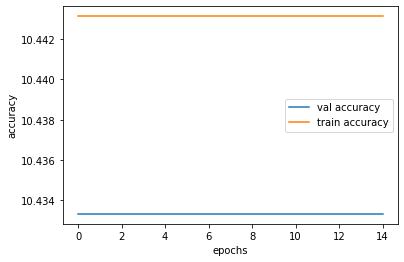

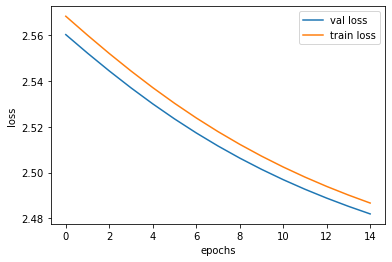

10.433333333333334

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.1**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: The accuracy value is 10.28 and the loss value is around 2.570895195007324
The accuracy graph shows the progress of the model accuracy over epochs, for the train and validation sets. as we can see, the accuracy graph is compused of 2 straight lines.
(which are around 10.4) so there isnt much learning rate, the reasons for that are that the dim of the network are too small (only 1) and the learning rate is also too small and not efficent
for the model. 
The loss graps shows the loss of the model over epochs, for the train and validation sets. the loss graph compused ot 2 lines which goes down in spiral line.
in the graph we see that the loss barerly changes, and that because the small dim of the network and the small learning rate.



#### hidden_layer_dim = 5, lr = 0.0001

Set the hidden_layer_dim to 5 and the lr to 0.0001 and train the model.

In [ ]:
args['hidden_layer_dim'] = 5
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 11.241176470588234, loss 2.358590102663227

Validation epoch 1: accuracy 11.3, loss 2.3550908300611706
========== new best model! epoch 1, accuracy 11.3  ==========

Train epoch 2: accuracy 11.241176470588234, loss 2.3565595570732567

Validation epoch 2: accuracy 11.3, loss 2.353156805038452

Train epoch 3: accuracy 11.239215686274509, loss 2.3545551159802605

Validation epoch 3: accuracy 11.3, loss 2.3512481848398843

Train epoch 4: accuracy 11.241176470588234, loss 2.352577106625426

Validation epoch 4: accuracy 11.3, loss 2.3493652873569064

Train epoch 5: accuracy 11.239215686274509, loss 2.350625884299185

Validation epoch 5: accuracy 11.3, loss 2.347508324517144

Train epoch 6: accuracy 11.24313725490196, loss 2.3487017248191084

Validation epoch 6: accuracy 11.3, loss 2.3456775082482233

Train epoch 7: accuracy 11.245098039215685, loss 2.3468048151801613

Validation epoch 7: accuracy 11.3, loss 2.3438731829325357

Train epoch 8: accuracy 11.2450980392156

Best val accuracy was 11.344444444444443, at epoch 13


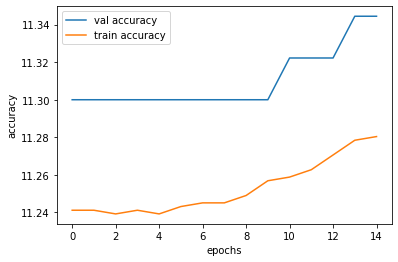

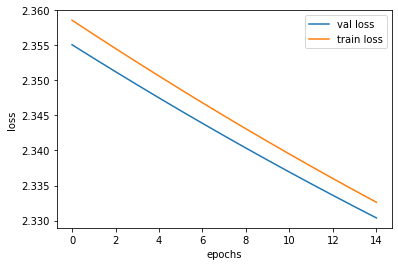

11.344444444444443

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.2**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: The accuracy is 11.42 and the loss value is 2.334763431549072
In the graph value we can see that throughthout epochs 0-8 the accuracy isn't improving and after epoch 9 to 14 there is an improvment but not much (11.30 to 11.34)
that because the dim of the network is small (only 5), and the learning rate is also too small (0.0001)

In the loss graph we can see the graph barerly improving the loss value from 2.36 to 2.33
that because the dim of the network is small (only 5), and the learning rate is also too small (0.0001)

#### hidden_layer_dim = 100, lr = 0.0001

Set the hidden_layer_dim to 100 and the lr to 0.0001 and train the model.

In [ ]:
args['hidden_layer_dim'] = 100
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 10.680392156862744, loss 2.3354450394125545

Validation epoch 1: accuracy 10.7, loss 2.334733804066976
========== new best model! epoch 1, accuracy 10.7  ==========

Train epoch 2: accuracy 10.776470588235295, loss 2.3333906659892962

Validation epoch 2: accuracy 10.756, loss 2.3326684368981256
========== new best model! epoch 2, accuracy 10.756  ==========

Train epoch 3: accuracy 10.888235294117646, loss 2.3313616958318972

Validation epoch 3: accuracy 10.833, loss 2.330628659990099
========== new best model! epoch 3, accuracy 10.833  ==========

Train epoch 4: accuracy 11.021568627450984, loss 2.329357563280592

Validation epoch 4: accuracy 11.0, loss 2.3286134931776257
========== new best model! epoch 4, accuracy 11.0  ==========

Train epoch 5: accuracy 11.121568627450978, loss 2.327377562429391

Validation epoch 5: accuracy 11.111, loss 2.3266225126054554
========== new best model! epoch 5, accuracy 11.111  ==========

Train epoch 6: accuracy 11.262745098

Best val accuracy was 12.322222222222223, at epoch 14


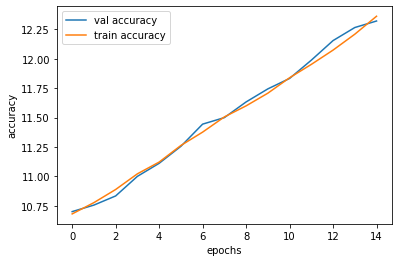

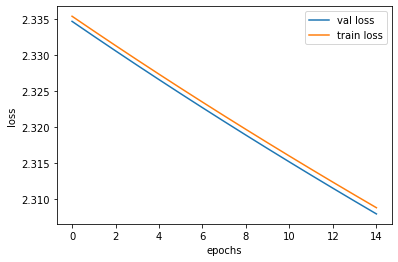

12.322222222222223

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.3**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: The accuracy is 12.32 and the loss value is 2.3116324186325072
We can see That the accuracy is *slightly* improving over the course of 14 epochs, that because the learning rate is very low.
The accuracy is improving faster from the previous test because the hidden dim is now 100 instead of 5.

The loss is also slight improving over the course of 14 epochs, for the same reasons as the accuracy.

#### hidden_layer_dim = 200, lr = 0.0001

Set the hidden_layer_dim to 200 and the lr to 0.0001 and train the model.

In [ ]:
args['hidden_layer_dim'] = 200
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 14.690196078431372, loss 2.3092044428283094

Validation epoch 1: accuracy 15.344, loss 2.304594569736057
========== new best model! epoch 1, accuracy 15.344  ==========

Train epoch 2: accuracy 15.178431372549017, loss 2.3068672628963696

Validation epoch 2: accuracy 15.889, loss 2.3023432625664606
========== new best model! epoch 2, accuracy 15.889  ==========

Train epoch 3: accuracy 15.83137254901961, loss 2.3045834279527853

Validation epoch 3: accuracy 16.511, loss 2.300142076280382
========== new best model! epoch 3, accuracy 16.511  ==========

Train epoch 4: accuracy 16.343137254901958, loss 2.3023497684329164

Validation epoch 4: accuracy 17.133, loss 2.29798870616489
========== new best model! epoch 4, accuracy 17.133  ==========

Train epoch 5: accuracy 16.966666666666665, loss 2.30016417129367

Validation epoch 5: accuracy 17.667, loss 2.295880768034193
========== new best model! epoch 5, accuracy 17.667  ==========

Train epoch 6: accuracy 17.59607

Best val accuracy was 23.166666666666668, at epoch 14


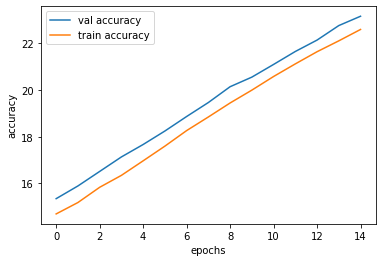

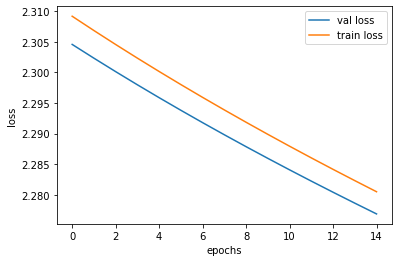

23.166666666666668

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.4**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: The accuracy is 23.64 and the loss value is 2.278033423423767
Over the duration of 14 epocs the accuracy is slightly improving. the accuracy is now better than the previous
test and thats because the number of hidden dim is 200 instead of 100 in the previous test.
the accuracy is slightly improving because the learning rate is small.

The loss is slightly improving and is better than the previous test for the same reasons as the accuracy.

### Finetuning learning rate

#### hidden_layer_dim = 100, lr = 0.000001

Set the hidden_layer_dim to 100 and the lr to 0.000001 and train the model.

In [ ]:
args['hidden_layer_dim'] = 100
args['lr']=0.000001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 10.601960784313727, loss 2.336448683458216

Validation epoch 1: accuracy 10.589, loss 2.3368041780259876
========== new best model! epoch 1, accuracy 10.589  ==========

Train epoch 2: accuracy 10.603921568627452, loss 2.336428071938309

Validation epoch 2: accuracy 10.589, loss 2.336783356136746

Train epoch 3: accuracy 10.607843137254902, loss 2.3364074931425205

Validation epoch 3: accuracy 10.6, loss 2.3367625077565513
========== new best model! epoch 3, accuracy 10.6  ==========

Train epoch 4: accuracy 10.607843137254903, loss 2.3363868675979913

Validation epoch 4: accuracy 10.6, loss 2.336741712358263

Train epoch 5: accuracy 10.607843137254902, loss 2.3363662934770772

Validation epoch 5: accuracy 10.6, loss 2.336720758014255

Train epoch 6: accuracy 10.609803921568627, loss 2.3363457380556594

Validation epoch 6: accuracy 10.6, loss 2.336699962615967

Train epoch 7: accuracy 10.611764705882354, loss 2.3363251499101225

Validation epoch 7: accuracy 10.

Best val accuracy was 10.6, at epoch 2


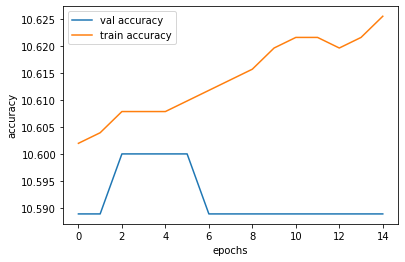

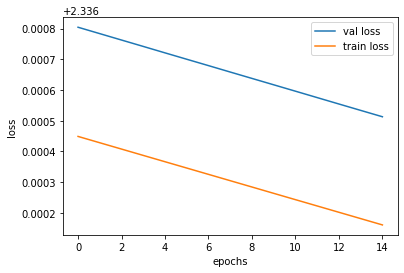

10.6

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 3.1**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: The accuracy is 10.620000000000001 and the loss value 2.3410150527954103
We can see that the best accuracy is between epoch 2 to 5, but the difference is minimal.
That because the learning rate is so small (really very close to 0), so the gradient doesn't improve and no learning occurs.
The hidden dim in this case doesnt help to improve much the accuracy.

We can see that the loss improvment is minimal, thats for the same reasons as the accuracy.

#### hidden_layer_dim = 100, lr = 0.1

Set the hidden_layer_dim to 1 and the lr to 0.1 and train the model.

In [ ]:
args['hidden_layer_dim'] = 100
args['lr']= 0.1
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 60.882352941176464, loss 1.7796717110802145

Validation epoch 1: accuracy 76.178, loss 1.2786129315694172
========== new best model! epoch 1, accuracy 76.178  ==========

Train epoch 2: accuracy 79.82745098039216, loss 1.0132485721625535

Validation epoch 2: accuracy 83.356, loss 0.8102732433213128
========== new best model! epoch 2, accuracy 83.356  ==========

Train epoch 3: accuracy 84.70784313725493, loss 0.7079598810158524

Validation epoch 3: accuracy 86.167, loss 0.6183443665504456
========== new best model! epoch 3, accuracy 86.167  ==========

Train epoch 4: accuracy 86.97450980392158, loss 0.5683280767179003

Validation epoch 4: accuracy 87.8, loss 0.518228593799803
========== new best model! epoch 4, accuracy 87.8  ==========

Train epoch 5: accuracy 88.2235294117647, loss 0.4901660499619503

Validation epoch 5: accuracy 88.6, loss 0.4580986698468526
========== new best model! epoch 5, accuracy 88.6  ==========

Train epoch 6: accuracy 88.95490196078

Best val accuracy was 91.53333333333335, at epoch 14


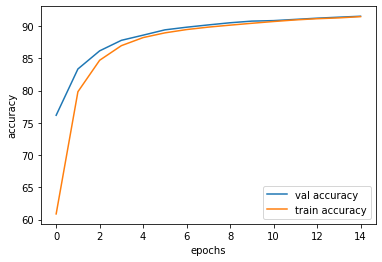

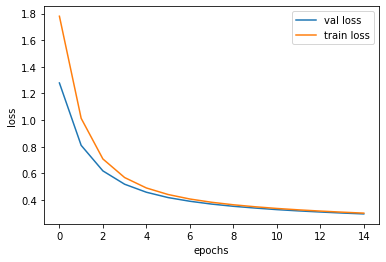

91.53333333333335

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 3.2**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: The accuracy is 92.09 and the loss is 0.2875345215201378
We can see that the accuracy is signifanctly improving for the first 5 epochs, afterwards its still improves but at a slower pace (because there isnt much to improve, the accuracy is high).
We got to that accuracy because the learning rate is bigger than the previous tests, and is more fitting to the model (not too big, not too small).

The loss at the graph decreases fast for the first 6 epochs (that because the learning rate is big), afterwards its decreases slowly.
In comparison to the previous tests, the loss is getting significantly smaller, that is because the learning rate is bigger in comparison and learning occurs.

#### hidden_layer_dim = 100, lr = 0.001

Set the hidden_layer_dim to 100 and the lr to 0.001 and train the model.

In [ ]:
args['hidden_layer_dim'] = 100
args['lr']=0.001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 11.3, loss 2.3265841007232666

Validation epoch 1: accuracy 11.189, loss 2.3174462053510876
========== new best model! epoch 1, accuracy 11.189  ==========

Train epoch 2: accuracy 12.572549019607841, loss 2.307916435540891

Validation epoch 2: accuracy 12.622, loss 2.300040774875217
========== new best model! epoch 2, accuracy 12.622  ==========

Train epoch 3: accuracy 13.862745098039216, loss 2.291110838160795

Validation epoch 3: accuracy 13.989, loss 2.284248802396986
========== new best model! epoch 3, accuracy 13.989  ==========

Train epoch 4: accuracy 15.437254901960786, loss 2.2757468878054152

Validation epoch 4: accuracy 15.456, loss 2.269708024130927
========== new best model! epoch 4, accuracy 15.456  ==========

Train epoch 5: accuracy 17.13529411764706, loss 2.2614946458853926

Validation epoch 5: accuracy 17.233, loss 2.2561319139268665
========== new best model! epoch 5, accuracy 17.233  ==========

Train epoch 6: accuracy 18.952941176470592, 

Best val accuracy was 50.41111111111111, at epoch 14


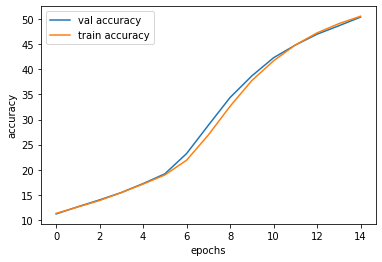

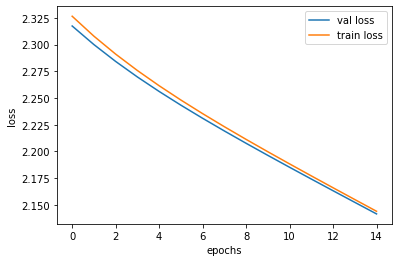

50.41111111111111

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 3.3**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: The accuracy is 51.01 and the loss value is 2.1381322622299193
In the graph we can see the accuracy constantly improving over the course of 14 ephocs. thats because the learning rate is not too small,
and learning occurs. In comparison to the previous test, the accuracy is lower because the learning is small.

The loss value slightly decreases over the epochs, that because the learning rate is low.

**QUESTION 4:** : Suggest a way to improve the results by changing the networks's architecture  

**ANSWER**: From the previous examples, we can see that the best test was when the lr was 0.1,
But, we can also see, from the previous tests that when the lr was constant and we "played" with the hidden dim, that the best result was when the hidden dim was the highest (200)
So, a way to improve the result would be to add more hidden dimensions while keeping the learning rate at 0.1.
A way to really improve the results would be to use the ADAM optimizer instead of STG, as was shown in class, the ADAM optimzer may outclass the STG (depending on the situation)
and will probably improve The accuracy and the loss value. Another thing that may improve the result may be normalization of the data, as was taught, greatly increases the learning.




## Explainability

Here we will plot some of the network weights.
**Be sure you run this cell with your best model!**

(784, 100)


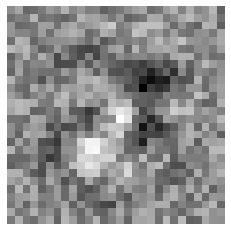

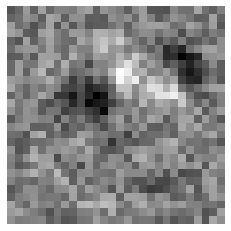

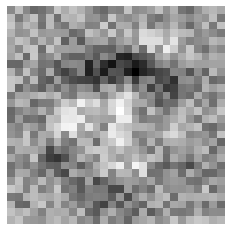

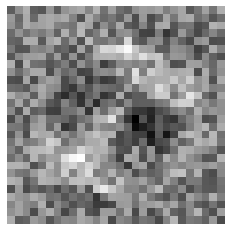

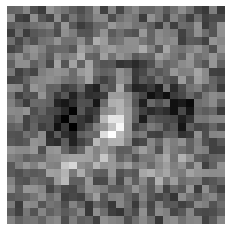

In [ ]:
# Visualize some weights. features of digits should be somehow present.
def show_net_weights(net_params):
    W1 = net_params.fc1.weight.cpu().data.numpy().T
    print(W1.shape)
    for i in range(5):
        W = W1[:,i*5].reshape(28, 28)
        plt.imshow(W,cmap='gray')
        plt.axis('off')
        plt.show()

show_net_weights(best_model)


**QUESTION 5:** Where are the bright regions? why?

**ANSWER:** the bright regions are in the center of the pictures, because the numbers are in
the center of the picture, and the network is looking for numbers.

In [16]:
%%shell
jupyter nbconvert --to html "/content/drive/MyDrive/HomeWorks/HomeWork-DeepLearning/assignment2/FullyConnectedNN.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/HomeWorks/HomeWork-DeepLearning/assignment2/FullyConnectedNN.ipynb to html
[NbConvertApp] Writing 674175 bytes to /content/drive/MyDrive/HomeWorks/HomeWork-DeepLearning/assignment2/FullyConnectedNN.html
